In [1]:
import torch
from torchmetrics import ConfusionMatrix
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision import datasets, transforms
import timm
from torchinfo import summary

import sys
from pathlib import Path
import os

sys.path.append("../")

import random
import json
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from pprint import pprint
import requests

from src.classification.evaluate import predictions
from src.classification.model import models
from src.data.generate_lego_part_classes import get_part_classes
from src.common import tools

from typing import Any, List, Union, Callable, Optional, Tuple

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Set path to data
data_path = Path("../data/classification/b200c-lego-classification-dataset")

part_class_path: Path = Path("../src/data/parts.csv")

image_paths: list[Path] = []
for root, dirs, _ in os.walk(data_path):
    for dir_name in dirs:
        folder_path: str = os.path.join(root, dir_name)
        subfolder_contents: list[str] = os.listdir(folder_path)

        if all(
            os.path.isfile(os.path.join(folder_path, item))
            for item in subfolder_contents
        ):
            image_paths.append(Path(root))
            break

cust_img_path = Path("C:/Users/chris/Documents/Images/lego/cropped_images")

image_path_list = list(itertools.chain.from_iterable([list(img_path.glob("*/*.jpg")) for img_path in image_paths]))
cust_img_path_list = list(cust_img_path.glob("*/*.jpg"))

image_paths, cust_img_path

([WindowsPath('../data/classification/b200c-lego-classification-dataset')],
 WindowsPath('C:/Users/chris/Documents/Images/lego/cropped_images'))

In [4]:
# Creating file with part id classes if not already created
part_ids = sorted(
    set([part for img_path in image_paths for part in os.listdir(img_path)])
)
class_names = []

class_dict = tools.part_cat_csv_to_dict(part_class_path)
for id in part_ids:
    part_class = tools.get_part_cat(part_id=id, id_to_cat=class_dict)
    if part_class not in class_names:
        class_names.append(part_class)
class_names = sorted(class_names, key=lambda x: x)
len(class_names)

27

In [5]:
# Loading torchvision model
tv_effnet_sorter, image_transform = models.get_tv_efficientnet_b0(num_classes=len(class_names), device=device)

tv_state_dict = torch.load(f="../models/classification/torchvision_models/efficientnet_b0_lego_sorterV7.pt", map_location=device)

#tv_effnet_sorter.load_state_dict(tv_state_dict)


# Loading timm model
timm_effnet_sorter, image_transform2 = models.get_timm_model(model_name="efficientnet_b0", num_classes=len(class_names), device=device)
timm_state_dict = torch.load(f="../models/classification/timm_models/efficientnet_b0_lego_classifierV0.pt", map_location=device)

#translated_state_dict = {timm_key: tv_param for timm_key, tv_param in zip(timm_state_dict.keys(), tv_state_dict.values())}

timm_effnet_sorter.load_state_dict(timm_state_dict)

<All keys matched successfully>

In [6]:
summary(model=timm_effnet_sorter, 
        input_size=(32, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                        [32, 3, 512, 512]    [32, 27]             --                   True
├─Conv2d (conv_stem)                               [32, 3, 512, 512]    [32, 32, 256, 256]   864                  True
├─BatchNormAct2d (bn1)                             [32, 32, 256, 256]   [32, 32, 256, 256]   64                   True
│    └─Identity (drop)                             [32, 32, 256, 256]   [32, 32, 256, 256]   --                   --
│    └─SiLU (act)                                  [32, 32, 256, 256]   [32, 32, 256, 256]   --                   --
├─Sequential (blocks)                              [32, 32, 256, 256]   [32, 320, 16, 16]    --                   True
│    └─Sequential (0)                              [32, 32, 256, 256]   [32, 16, 256, 256]   --                   True
│    │    └─DepthwiseSeparableConv (0)         

In [7]:
IMG_EXTENSIONS = (
    ".jpg",
    ".jpeg",
    ".png",
    ".ppm",
    ".bmp",
    ".pgm",
    ".tif",
    ".tiff",
    ".webp",
)

# Custom Dataset class for altering the labels of the dataset
class PartSortingDataset(datasets.DatasetFolder):
    def __init__(
        self,
        root: Union[str, Path],
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = datasets.folder.default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
            allow_empty=allow_empty,
        )
        self.imgs = self.samples

        if self.target_transform is not None:
            transformed_classes = set(sorted(self.target_transform(_class) for _class in self.classes))
            transformed_to_idx = {transformed: idx for idx, transformed in enumerate(transformed_classes)}
            target_to_transformed = {self.class_to_idx[target]: transformed_to_idx[self.target_transform(target)] for target in self.classes}

            self.transformed_classes = transformed_classes
            self.transformed_to_idx = transformed_to_idx
            self.target_to_transformed = target_to_transformed

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        
        target_to_transformed = self.target_to_transformed

        path, target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = target_to_transformed[target]

        return sample, target

    def __len__(self) -> int:
        return len(self.imgs)


In [8]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform = None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [13]:
IMAGE_SIZE = 256

for transform in image_transform2.transforms:  # type: ignore
    if type(transform) in (
        transforms.transforms.Resize,
        transforms.transforms.CenterCrop,
    ):
        transform.size = IMAGE_SIZE

In [14]:
# Make data folder into dataset
def target_transform(target):
    return tools.get_part_cat(target, class_dict)

independent_datasets: list[PartSortingDataset] = []
for path in image_paths:
    independent_datasets.append(
        PartSortingDataset(
            root=path, transform=image_transform2, target_transform=target_transform
        )
    )

full_dataset = ConcatDataset(independent_datasets)

print(f"Dataset length: {len(full_dataset)}")

sample, label = full_dataset[0]  # Access the first sample
#print(f"Sample size: {sample.size()}, Label: {label}")

Dataset length: 800000


In [15]:
# Split into training and testing data
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_data, test_data = random_split(full_dataset, [train_size, test_size], generator=torch.manual_seed(0))

print(f"{len(train_data)}\n{len(test_data)}")

640000
160000


In [18]:
sample, label = train_data[0]  # Access the first sample
print(f"Sample size: {sample.size()}, Label: {label}")

Sample size: torch.Size([3, 256, 256]), Label: 23


In [19]:
BATCH_SIZE = 128
NUM_WORKERS = 0
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Make dataset into dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

Creating DataLoader's with batch size 128 and 0 workers.


(5000, 1250)

In [20]:
transformed_to_idx = {}
idx_to_transformed = {}

for d_set in full_dataset.datasets:
    transformed_to_idx.update(d_set.transformed_to_idx)
    idx_to_transformed.update({idx: trans for trans, idx in d_set.transformed_to_idx.items()})

list(idx_to_transformed.values())

[np.int64(3),
 np.int64(5),
 np.int64(6),
 np.int64(8),
 np.int64(9),
 np.int64(11),
 np.int64(12),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(23),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(32),
 np.int64(37),
 np.int64(46),
 np.int64(49),
 np.int64(51),
 np.int64(53),
 np.int64(54),
 np.int64(67),
 np.int64(68)]

In [34]:
def test_step(
    model,
    dataloader,
    device: torch.device,
):

    model.eval()

    test_acc = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = test_acc / len(dataloader)
    return test_acc

In [81]:
acc = test_step(timm_effnet_sorter, test_dataloader, device)
acc

100%|██████████| 2341/2341 [20:41<00:00,  1.89it/s]


0.6599098497792966

In [41]:
preds = []

img_iters = image_path_list
random.shuffle(img_iters)

for path in tqdm(img_iters[:100]):
    with open(path, 'rb') as img_file:
        # Prepare the files dictionary for the request
        files = {'query_image': ('image.jpg', img_file, 'image/jpeg')}

        response = requests.post('https://api.brickognize.com/predict/parts/', headers={'accept': 'application/json'}, files=files).json()

    if response["items"]:
        y_pred_class = response["items"][0]["id"]
        target_class = str(path.parent.name)

        preds.append(1 if y_pred_class == target_class else 0)
        #tqdm.write(f"{y_pred_class}, {target_class}")
    else:
        preds.append(0)

acc = sum(preds) / len(preds)

acc

 14%|█▍        | 14/100 [00:05<00:32,  2.64it/s]


KeyboardInterrupt: 

In [50]:
preds = []

img_iters = image_path_list
random.shuffle(img_iters)

for path in tqdm(img_iters[:1000]):
    y_pred = predictions.pred_image(model=timm_effnet_sorter,
                    image_path=path,
                    transform=image_transform)
    y_pred_class = int(class_names[y_pred])
    target_class = int(tools.get_part_cat(str(path.parent.name), class_dict))

    preds.append(1 if y_pred_class == target_class else 0)

acc = sum(preds) / len(preds)

acc

100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]


0.989

Correct class:  21


WindowsPath('../data/classification/b200c-lego-classification-dataset/4073/2984.jpg')

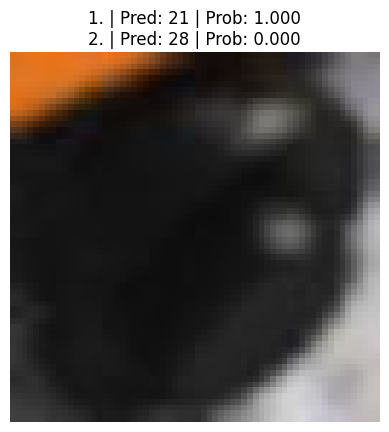

In [33]:
random_image_path: Path = random.choice(image_path_list)
predictions.pred_and_plot_image(model=timm_effnet_sorter,
                    class_names=class_names,
                    image_path=random_image_path,
                    transform=image_transform2)
target_class = tools.get_part_cat(str(random_image_path.parent.name), class_dict)
print(f"Correct class:  {target_class}")

random_image_path

In [ ]:
# 1. Make predictions with trained model
y_preds = []
timm_effnet_sorter.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)

    y_logit = timm_effnet_sorter(X)
    
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 2341/2341 [33:04<00:00,  1.18it/s]


In [153]:
test_targets = torch.tensor([class_names[label] for _, label in tqdm(test_data)])

test_targets

100%|██████████| 299523/299523 [11:25<00:00, 436.76it/s]


tensor([14, 23, 28,  ..., 11, 32, 67])

In [152]:
conv_y_pred_tensor = torch.tensor([int(class_names[idx]) for idx in y_pred_tensor.tolist()])
conv_y_pred_tensor

tensor([14, 23,  3,  ...,  3, 32,  3])

In [154]:
len(set(torch.unique(test_targets).tolist()))

36

In [159]:
res = [1 if p == t else 0 for p, t in zip(conv_y_pred_tensor, test_targets)]
acc = sum(res) / len(res)
acc

0.6600461400293133

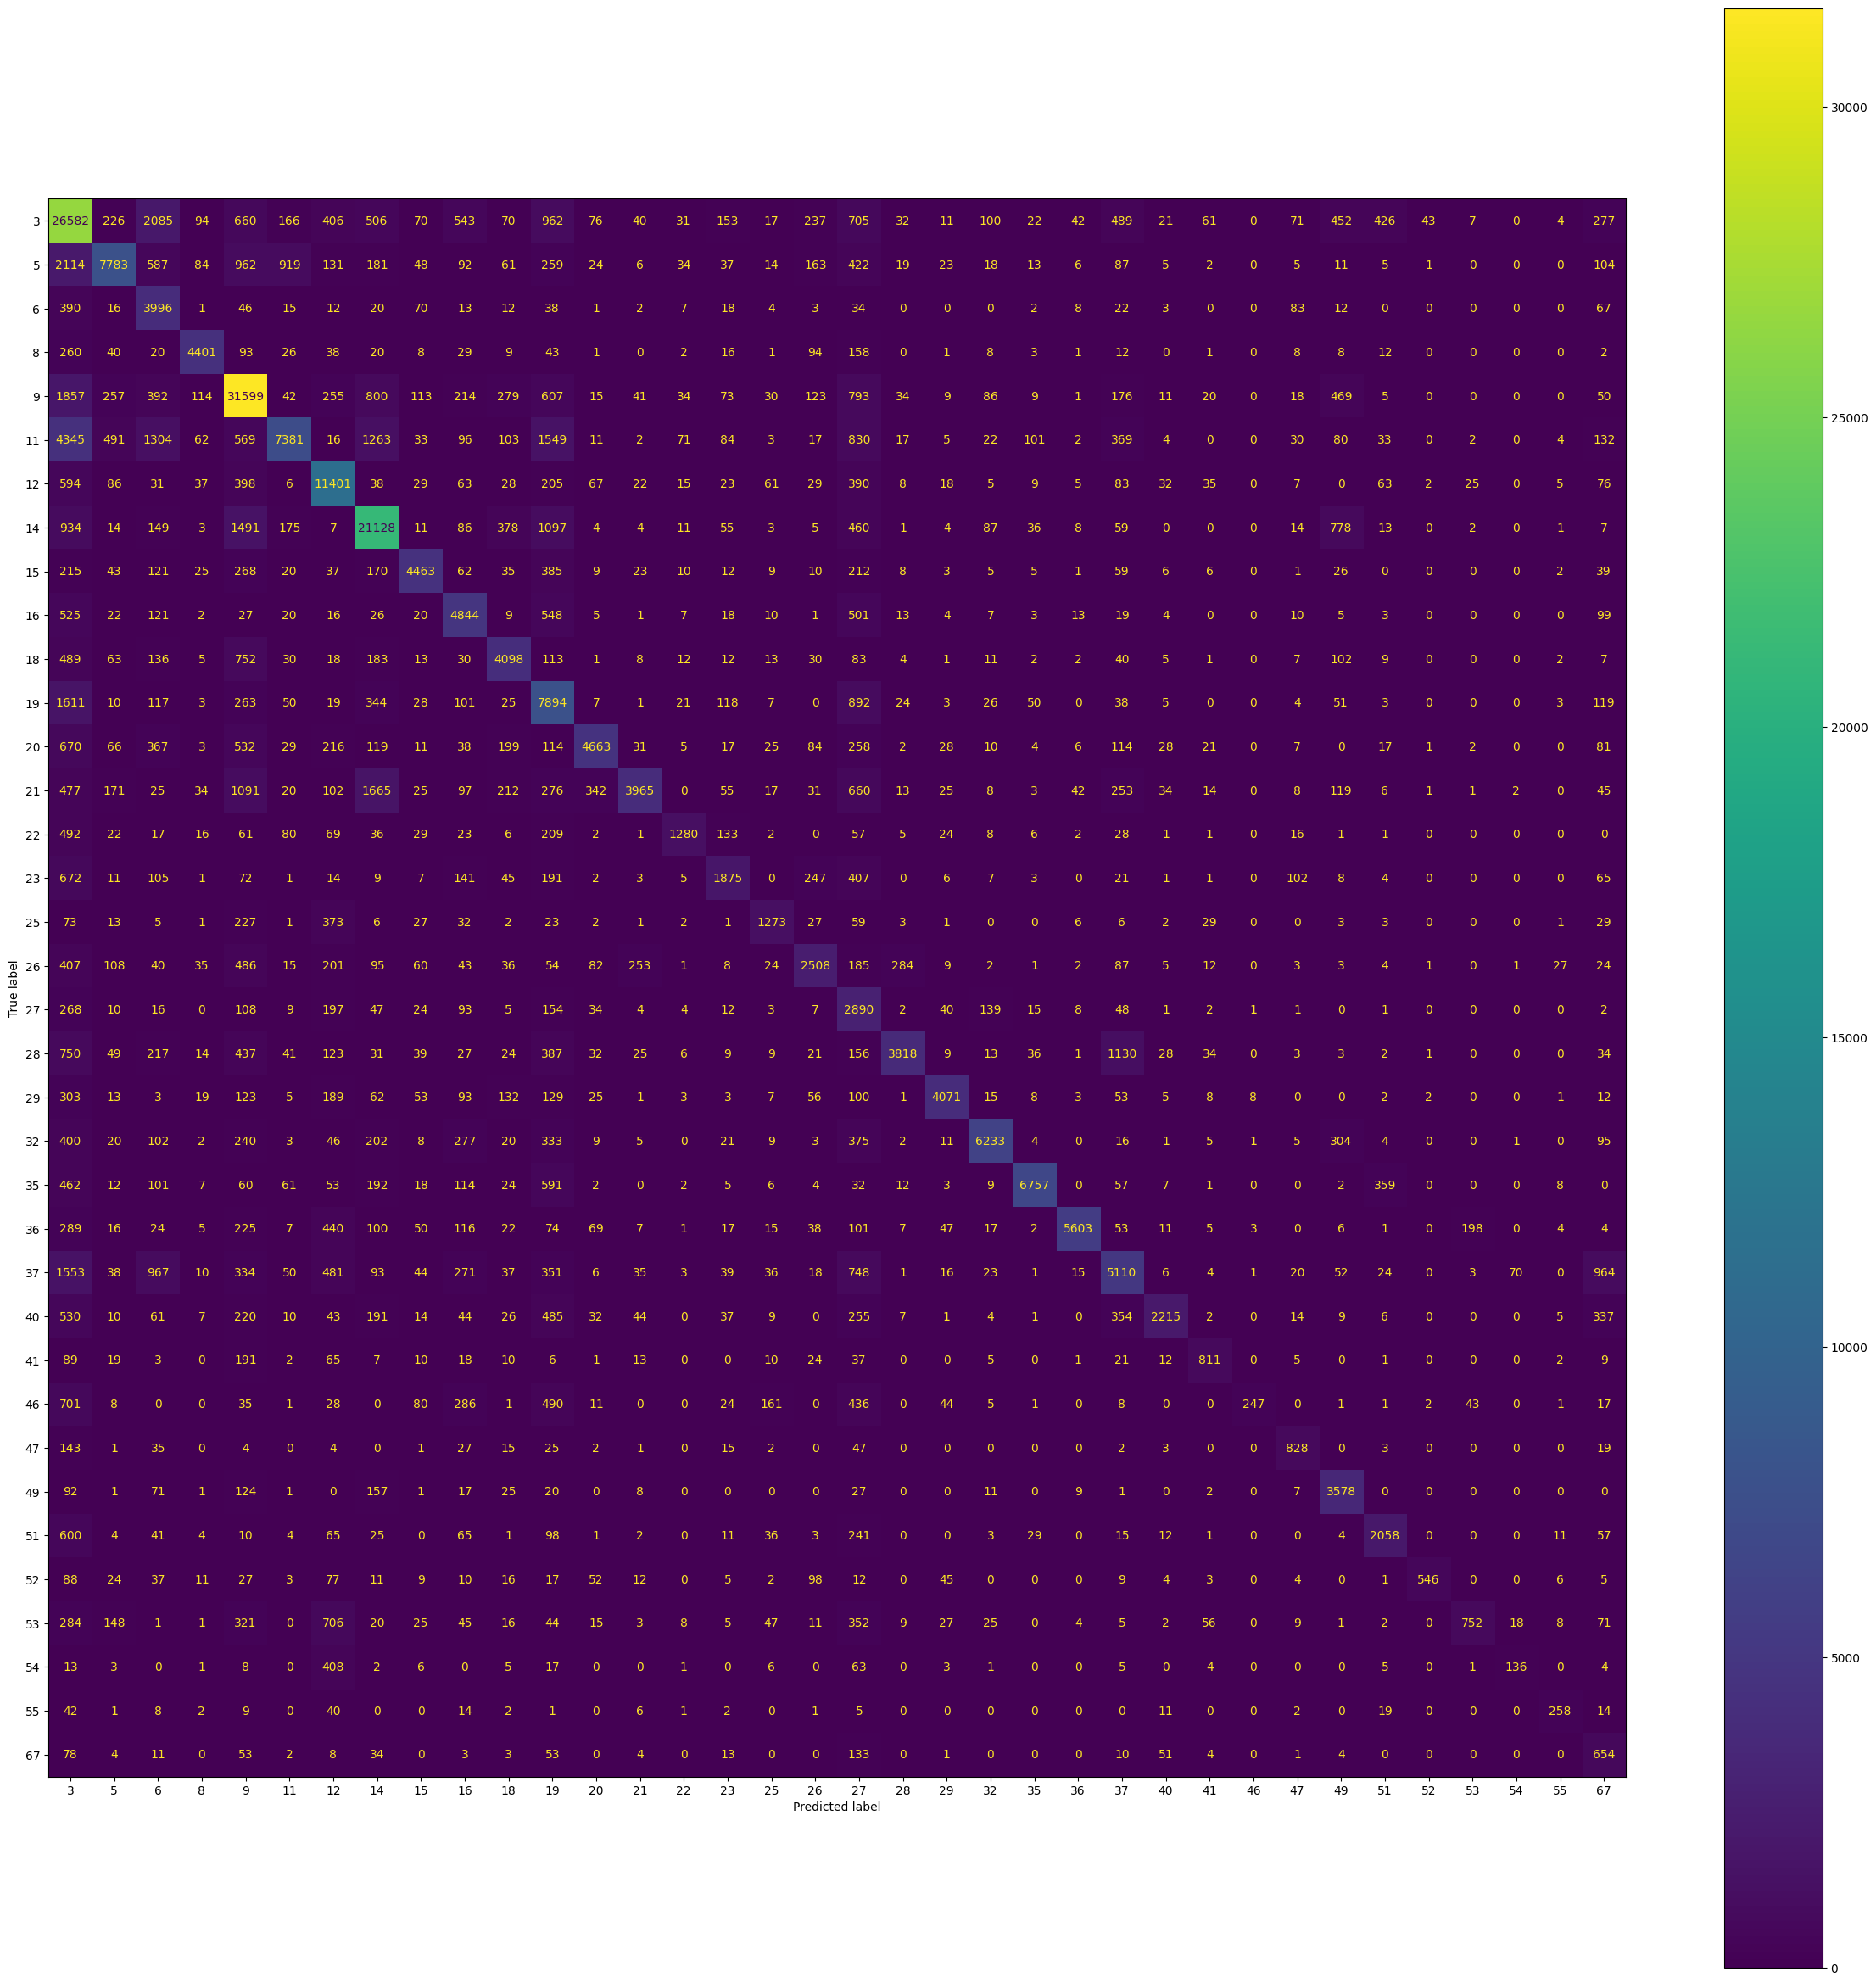

In [155]:
# Print a confusion matrix
cm = confusion_matrix(test_targets, conv_y_pred_tensor)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(torch.unique(test_targets).tolist()))

fig, ax = plt.subplots(figsize=(30, 30))
cmp.plot(ax=ax)